# Step 7: Variational AutoEncoder

## vae.py

54.04760594482422
45.27690699462891
43.45118411661784
42.353020381673176
41.59895751953125
41.1040569539388
40.69368239135742
40.43008690795899
40.17481178385417
39.9674096862793
39.848685054524736
39.72178508911133
39.589868845621744
39.52174467366537
39.35550798950195
39.27299399210612
39.25872007242839
39.119287900797524
39.09951305745443
39.03094169311523
38.97456183064779
38.88335710245768
38.87019775390625
38.781715563964845
38.76531099039713
38.71284223632812
38.67515536295573
38.617891853841144
38.5958486714681
38.60076022338867


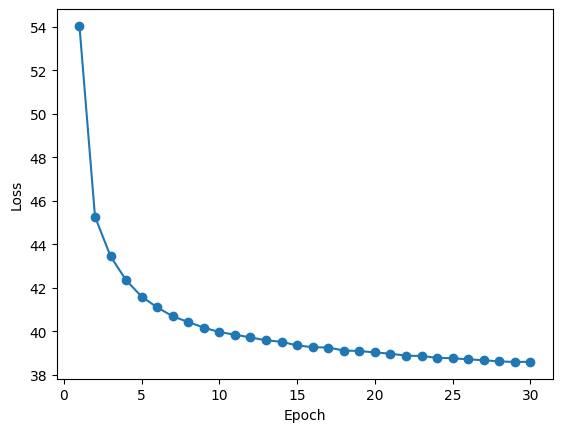

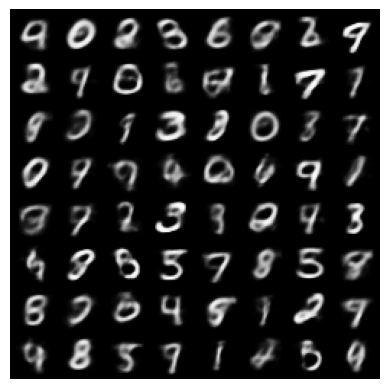

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms


# hyperparameters
input_dim = 784  # x dimension
hidden_dim = 200  # neurons in hidden layers
latent_dim = 20  # z dimension
epochs = 30
learning_rate = 3e-4
batch_size = 32


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)
        return x_hat


def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)
        return (L1 + L2) / batch_size


# datasets
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(torch.flatten) # falatten
            ])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    print(loss_avg)
    losses.append(loss_avg)

# plot losses
epochs = list(range(1, epochs + 1))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# generate new images
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, latent_dim)
    x = model.decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()